In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np

from package.helpers import test_physical_lens
from package.plots import diagnostic_plot, plot

/data/bwedig/.conda/envs/pandeia/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors

rc('font', **{'family':'serif', 'serif':['Computer Modern Roman'], 'monospace': ['Computer Modern Typewriter']})
rc('text', usetex=True)

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'

In [4]:
figure_dir = os.path.join(repo_path, 'figures')
array_dir = os.path.join(repo_path, 'output', 'arrays')

# Generate images with various PSFs

In [5]:
physical_lens = test_physical_lens.TestPhysicalLens()

num_pix = 45
band = 'f106'

## No PSF

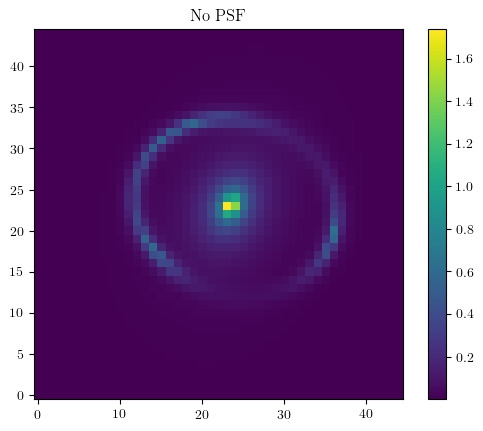

(45, 45)


In [6]:
kwargs_psf_none = {'psf_type': 'NONE'}

no_psf = physical_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_none)

plot.plot(filepath=None,
          title='No PSF',
          array=no_psf,
          colorbar=True)

print(no_psf.shape)

## Gaussian PSF

I'm getting the PSF FWHM values from [here](https://roman.gsfc.nasa.gov/science/WFI_technical.html). From that webpage: "Note: PSF FWHM in arcseconds simulated at the center of the center pixel of a detector near the center of the WFI FOV using an input spectrum for a K0V type star."

In [7]:
psf_fwhm = {
    'f062': 0.058,
    'f087': 0.073,
    'f106': 0.087,
    'f129': 0.105,
    'f158': 0.127,
    'f184': 0.151,
    'f213': 0.175,
    'f146': 0.105
}

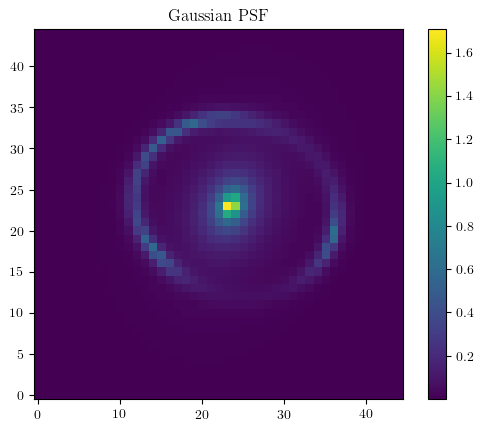

(45, 45)


In [8]:
kwargs_psf_gaussian = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm.get(band)}

gaussian_psf = physical_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_gaussian)

plot.plot(filepath=None,
          title='Gaussian PSF',
          array=gaussian_psf,
          colorbar=True)

print(gaussian_psf.shape)

## `lenstronomy` Roman module, which uses a pixel PSF

Not sure where they got the PSFs and under what conditions they were generated, but they're `.fits` files

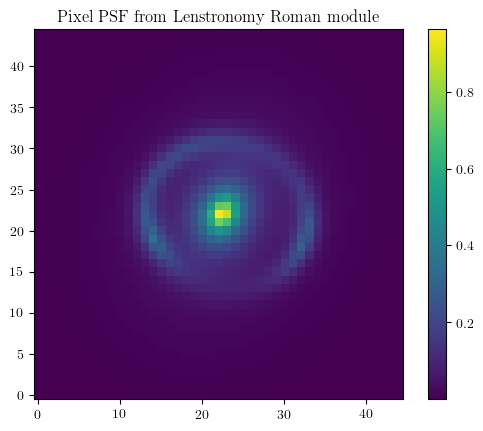

(45, 45)


In [9]:
pixel_psf, _, _ = physical_lens.get_roman_sim(noise=False)

plot.plot(filepath=None,
          title='Pixel PSF from Lenstronomy Roman module',
          array=pixel_psf,
          colorbar=True)

print(pixel_psf.shape)

# Compare

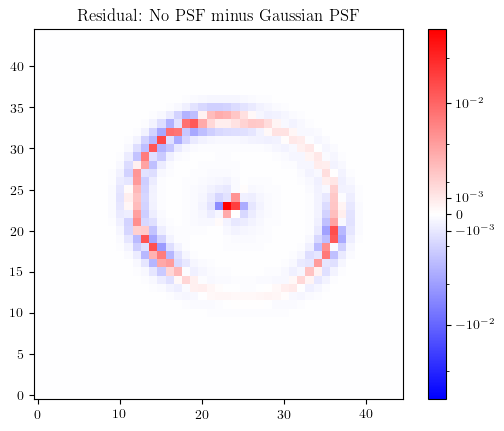

In [10]:
diagnostic_plot.residual(None, 'Residual: No PSF minus Gaussian PSF', no_psf, gaussian_psf)

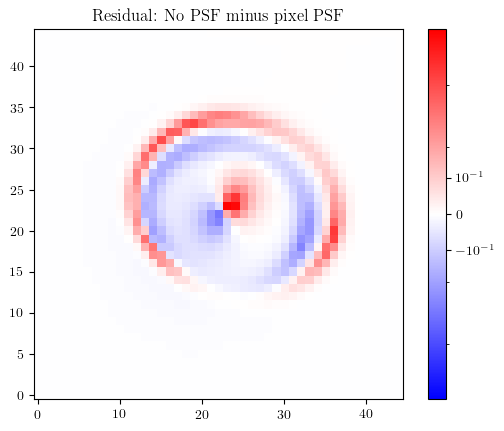

In [11]:
diagnostic_plot.residual(None, 'Residual: No PSF minus pixel PSF', no_psf, pixel_psf)

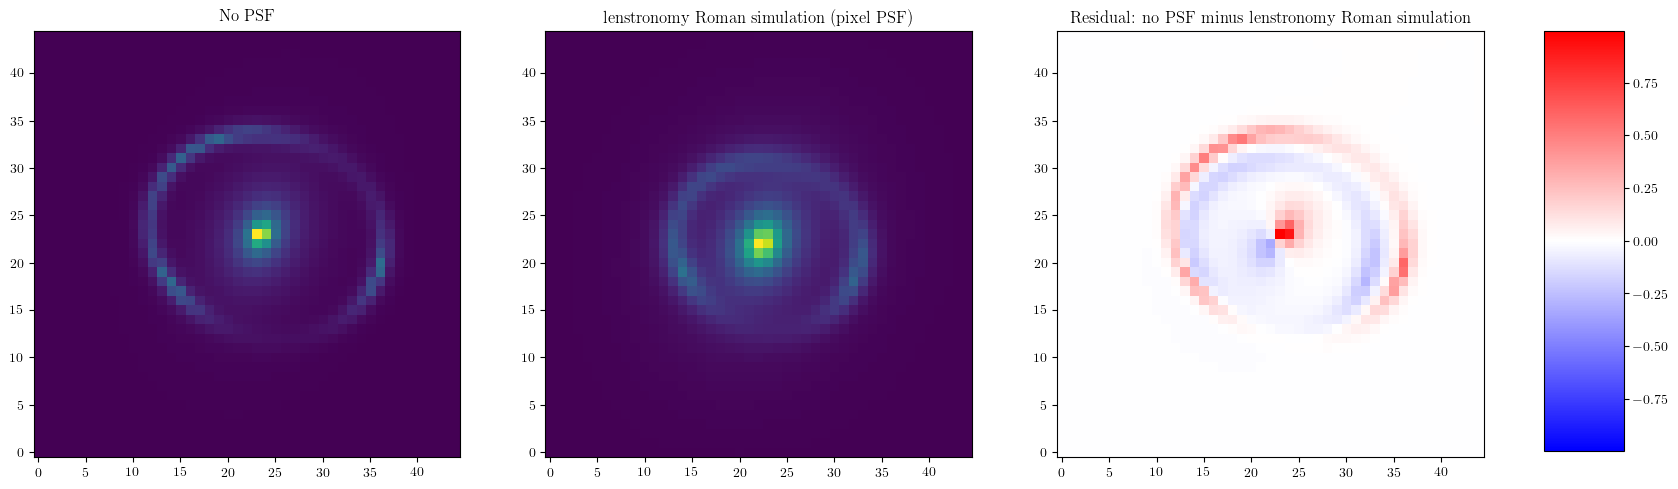

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

residual = no_psf - pixel_psf
abs_min, abs_max = abs(np.min(residual)), abs(np.max(residual))
limit = np.max([abs_min, abs_max])

im0 = axes[0].imshow(no_psf)
im1 = axes[1].imshow(pixel_psf)
im2 = axes[2].imshow(residual, vmin=-limit, vmax=limit, cmap='bwr')

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

axes[0].set_title('No PSF')
axes[1].set_title('lenstronomy Roman simulation (pixel PSF)')
axes[2].set_title('Residual: no PSF minus lenstronomy Roman simulation')

plt.show()

# Combine

In [13]:
pandeia = np.load(os.path.join(array_dir, 'detector_no_noise_or_background_1.npy'))

In [14]:
def get_limit(array):
    abs_min, abs_max = abs(np.min(array)), abs(np.max(array))
    return np.max([abs_min, abs_max])

def get_linear_width(array):
    return np.abs(np.mean(array) + (3 * np.std(array)))

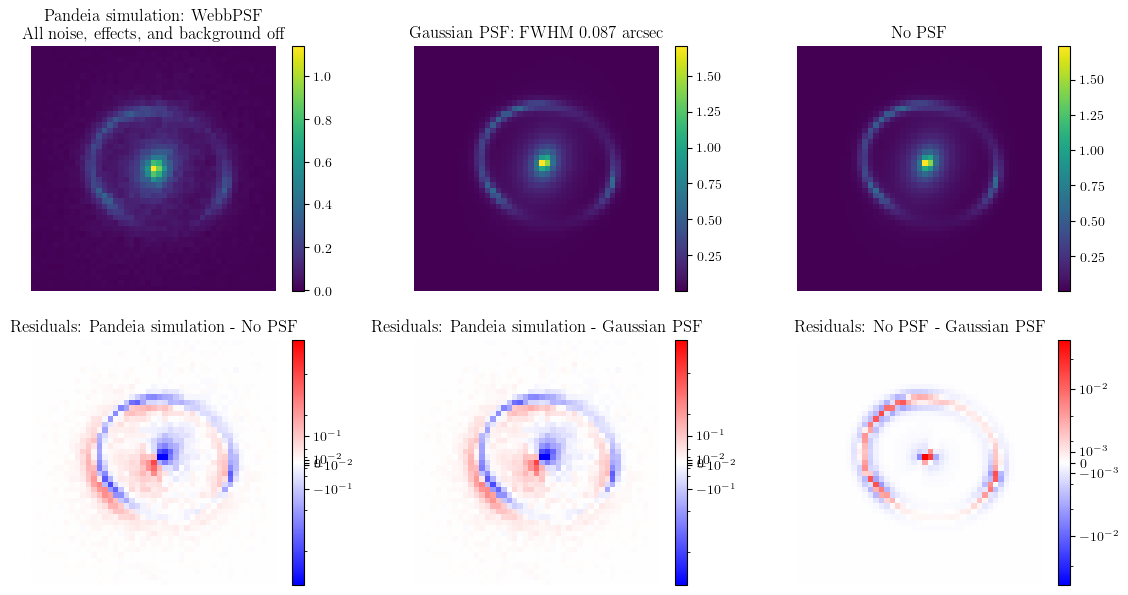

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,7))

ax0 = ax[0,0].imshow(pandeia)
ax1 = ax[0,1].imshow(gaussian_psf)
ax2 = ax[0,2].imshow(no_psf)
ax3 = ax[1,0].imshow(pandeia - no_psf, cmap='bwr', norm=colors.AsinhNorm(linear_width=get_linear_width(pandeia - no_psf), vmin=-get_limit(pandeia - no_psf), vmax=get_limit(pandeia - no_psf)))
ax4 = ax[1,1].imshow(pandeia - gaussian_psf, cmap='bwr', norm=colors.AsinhNorm(linear_width=get_linear_width(pandeia - gaussian_psf), vmin=-get_limit(pandeia - gaussian_psf), vmax=get_limit(pandeia - gaussian_psf)))
ax5 = ax[1,2].imshow(no_psf - gaussian_psf, cmap='bwr', norm=colors.AsinhNorm(linear_width=get_linear_width(no_psf - gaussian_psf), vmin=-get_limit(no_psf - gaussian_psf), vmax=get_limit(no_psf - gaussian_psf)))

ax[0,0].set_title('Pandeia simulation: WebbPSF\nAll noise, effects, and background off')
ax[0,1].set_title(f'Gaussian PSF: FWHM {psf_fwhm.get(band)} arcsec')
ax[0,2].set_title('No PSF')
ax[1,0].set_title('Residuals: Pandeia simulation - No PSF')
ax[1,1].set_title('Residuals: Pandeia simulation - Gaussian PSF')
ax[1,2].set_title('Residuals: No PSF - Gaussian PSF')

ax[0,0].set_axis_off()
ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,0].set_axis_off()
ax[1,1].set_axis_off()
ax[1,2].set_axis_off()

plt.colorbar(ax0, ax=ax[0,0])
plt.colorbar(ax1, ax=ax[0,1])
plt.colorbar(ax2, ax=ax[0,2])
plt.colorbar(ax3, ax=ax[1,0])
plt.colorbar(ax4, ax=ax[1,1])
plt.colorbar(ax5, ax=ax[1,2])

# ax[1,2].remove()

plt.savefig(os.path.join(figure_dir, 'comparing_psfs.png'))
plt.show()